In [ ]:
%reload_ext autoreload
%autoreload 2

import io
import os

import numpy as np
import pandas as pd
import requests
from dotenv import load_dotenv
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

from src.database import DICdb
from src.visualization import plot_dic_vectors

%matplotlib widget

load_dotenv()

DB_HOST = os.environ.get("DB_HOST", "150.145.51.193")
DB_PORT = os.environ.get("DB_PORT", "5432")
DB_NAME = os.environ.get("DB_NAME", "planpincieux")
DB_USER = os.environ.get("DB_USER", "")
DB_PASSWORD = os.environ.get("DB_PASSWORD", "")

APP_HOST = "150.145.51.193"
APP_PORT = 8001
IMG_GET_API_BASEURL = f"http://{DB_HOST}:{APP_PORT}/pics/image/"

db = DICdb(
    host=DB_HOST, port=DB_PORT, database=DB_NAME, user=DB_USER, password=DB_PASSWORD
)

target_date = "2024-08-23"
dic_analysis_id = 3098

In [8]:
# Get DIC data for the target date
dic_data = db.get_dic_data(target_date=target_date)

# Filter a specific DIC analysis
dic_data = dic_data[dic_data["analysis_id"] == dic_analysis_id]

# Get the master image for the DIC analysis
master_image_id = dic_data["master_image_id"].iloc[0]
response = requests.get(IMG_GET_API_BASEURL + f"{master_image_id}/")
img = Image.open(io.BytesIO(response.content))

In [9]:
columns_to_extract = {
    "seed_x_px": "x",
    "seed_y_px": "y",
    "displacement_x_px": "u",
    "displacement_y_px": "v",
    "displacement_magnitude_px": "V",
}
df = dic_data[columns_to_extract.keys()].rename(columns=columns_to_extract)

# Filter out low velocity vectors
min_velocity = 0.5  # Minimum velocity threshold in pixels
df = df[df["V"] >= min_velocity].reset_index(drop=True)

(<Figure size 800x500 with 2 Axes>,
 <Axes: >,
 <matplotlib.quiver.Quiver at 0x74604afdb2f0>)

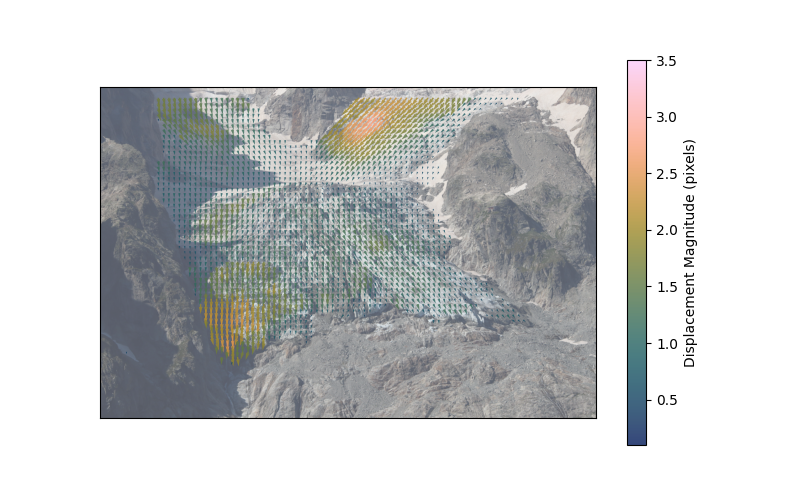

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))
plot_dic_vectors(
    x=df["x"],
    y=df["y"],
    u=df["u"],
    v=df["v"],
    magnitudes=df["V"],
    background_image=img,
    cmap_name="batlow",
    vmin=0.1,
    vmax=3.5,
    fig=fig,
    ax=ax,
)

In [ ]:
def preproc_features(df):
    """
    Create additional features for clustering glacier displacement data
    """
    df_features = df.copy()

    # Direction angle (in radians and degrees)
    df_features["angle_rad"] = np.arctan2(df["v"], df["u"])
    df_features["angle_deg"] = np.degrees(df_features["angle_rad"])

    # Convert negative angles to positive (0-360 degrees)
    df_features["angle_deg"] = (df_features["angle_deg"] + 360) % 360

    # Directional components (unit vectors)
    df_features["u_unit"] = df["u"] / (df["V"] + 1e-10)  # Avoid division by zero
    df_features["v_unit"] = df["v"] / (df["V"] + 1e-10)

    # Spatial derivatives (approximate gradients)
    # Note: This is a simplified approach - in practice you might want to use proper spatial interpolation
    df_features["spatial_index"] = range(len(df_features))

    # Log magnitude for better clustering of different scales
    df_features["log_magnitude"] = np.log1p(df["V"])

    # Magnitude categories
    magnitude_percentiles = np.percentile(df["V"], [25, 50, 75])
    df_features["magnitude_category"] = pd.cut(
        df["V"],
        bins=[0] + list(magnitude_percentiles) + [np.inf],
        labels=["low", "medium", "high", "very_high"],
    )

    return df_features


def normalize_data(
    df,
    spatial_weight=0.3,
    velocity_weight=0.7,
    spatial_features_names=None,
    velocity_features_names=None,
):
    """
    Custom clustering approach that considers both spatial proximity and velocity similarity

    Parameters:
    - spatial_weight: weight for spatial coordinates (x, y)
    - velocity_weight: weight for velocity features (u, v, magnitude, direction)
    """

    if spatial_features_names is None:
        spatial_features_names = ["x", "y"]
    if velocity_features_names is None:
        velocity_features_names = ["u", "v", "V", "angle_deg"]

    # Prepare features for clustering
    spatial_features = df[spatial_features_names].values
    velocity_features = df[velocity_features_names].values

    # Normalize features separately
    spatial_scaler = StandardScaler()
    velocity_scaler = StandardScaler()

    spatial_normalized = spatial_scaler.fit_transform(spatial_features)
    velocity_normalized = velocity_scaler.fit_transform(velocity_features)

    # Create a DataFrame with normalized features
    normalized_df = pd.DataFrame(
        np.hstack(
            [
                spatial_normalized * spatial_weight,
                velocity_normalized * velocity_weight,
            ]
        ),
        columns=spatial_features_names + velocity_features_names,
    )

    return normalized_df, spatial_scaler, velocity_scaler


def visualize_uv_plt(df, ax=None, **kwargs):
    """
    Visualize the u-v scatter plot with optional background image.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))

    V = df["V"].values if "V" in df else np.sqrt(df["u"] ** 2 + df["v"] ** 2)
    scatter = ax.scatter(
        df["u"], df["v"], s=1, c=V, alpha=0.6, cmap="viridis", **kwargs
    )
    ax.set_xlabel("u (displacement in x direction)")
    ax.set_ylabel("v (displacement in y direction)")
    ax.set_title("Displacement Vectors (u-v Scatter Plot)")
    plt.colorbar(scatter, ax=ax)
    ax.set_aspect("equal", adjustable="box")


def visualize_pca(df, columns_to_extract=None, normalize=False):
    "visualize the enhanced features using PCA for dimensionality reduction"
    from sklearn.decomposition import PCA

    # Prepare data for PCA
    if columns_to_extract is None:
        columns_to_extract = ["x", "y", "u", "v", "V", "angle_deg"]

    # Ensure all required columns are present in the DataFrame
    missing_columns = set(columns_to_extract) - set(df.columns)
    if missing_columns:
        raise ValueError(f"Missing columns in DataFrame: {missing_columns}")

    if normalize:
        scaler = StandardScaler()
        data = scaler.fit_transform(df[columns_to_extract])
    else:
        data = df[columns_to_extract].values

    # Reduce to 2D using PCA
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)
    df_reduced = pd.DataFrame(reduced_data, columns=["PC1", "PC2"])

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.scatter(df_reduced["PC1"], df_reduced["PC2"], s=1, alpha=0.6)
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.set_title("PCA Reduced Features Scatter Plot")
    ax.set_aspect("equal", adjustable="box")


def plot_clustering_results(df, labels, var_names=None, img=None, figsize=(15, 10)):
    """
    Visualize clustering results on the glacier displacement field.
    Simplified version inspired by plot_dic_vectors function.
    """
    fig, axes = plt.subplots(2, 2, figsize=figsize)

    # Get unique labels and create colors
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels[unique_labels >= 0])  # Exclude noise (-1)

    # Use a colormap for consistent colors
    if n_clusters > 0:
        cmap = plt.get_cmap("Set3")
        colors = cmap(np.linspace(0, 1, max(n_clusters, 3)))
        # Handle noise points with red color
        color_map = {}
        cluster_idx = 0
        for label in unique_labels:
            if label == -1:
                color_map[label] = "red"
            else:
                color_map[label] = colors[cluster_idx % len(colors)]
                cluster_idx += 1
    else:
        color_map = {-1: "red"}

    # Plot 1: Spatial distribution of clusters
    ax1 = axes[0, 0]
    for label in unique_labels:
        mask = labels == label
        if np.any(mask):
            cluster_name = "Noise" if label == -1 else f"Cluster {label}"
            ax1.scatter(
                df.loc[mask, "x"],
                df.loc[mask, "y"],
                c=[color_map[label]],
                s=2,
                alpha=0.7,
                label=cluster_name,
            )

    ax1.set_title("Spatial Distribution")
    ax1.invert_yaxis()  # Match image coordinates
    ax1.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    ax1.set_aspect("equal")
    ax1.grid(False)
    ax1.set_xlabel("")
    ax1.set_ylabel("")
    ax1.set_xticks([])
    ax1.set_yticks([])

    # Plot 2: Displacement vectors colored by velocity magnitude (like plot_dic_vectors)
    ax2 = axes[0, 1]
    if img is not None:
        ax2.imshow(img, alpha=0.7)
    q = ax2.quiver(
        df["x"],
        df["y"],
        df["u"],
        df["v"],
        df["V"],  # Color by velocity magnitude
        scale=None,
        scale_units="xy",
        angles="xy",
        cmap="viridis",
        width=0.003,
        headwidth=2.5,
        alpha=0.8,
    )
    cbar = fig.colorbar(q, ax=ax2)
    cbar.set_label("Displacement Magnitude (pixels)")
    ax2.set_title("Displacement Vectors")
    ax2.grid(False)
    ax2.set_aspect("equal")
    ax2.set_xlabel("")
    ax2.set_ylabel("")
    ax2.set_xticks([])
    ax2.set_yticks([])

    # Plot 3: 2D scatter plot of two variables (e.g., angle vs magnitude)
    ax3 = axes[1, 0]
    if var_names is None:
        var_names = ["angle_deg", "V"]
    if len(var_names) != 2:
        raise ValueError(
            "var_names must contain exactly two variable names for the 2D scatter plot."
        )
    if not all(var in df.columns for var in var_names):
        raise ValueError(
            f"One or both of the specified variables {var_names} do not exist in the DataFrame."
        )
    for label in unique_labels:
        mask = labels == label
        if np.any(mask):
            cluster_name = "Noise" if label == -1 else f"Cluster {label}"
            ax3.scatter(
                df.loc[mask, var_names[0]],
                df.loc[mask, var_names[1]],
                c=[color_map[label]],
                s=15,
                alpha=0.6,
                label=cluster_name,
            )
    ax3.set_title("2D Scatter Plot")
    ax3.set_xlabel(var_names[0])
    ax3.set_ylabel(var_names[1])
    ax3.grid(True, alpha=0.3)
    ax3.legend()

    # Plot 4: Cluster statistics
    ax4 = axes[1, 1]
    cluster_stats = []
    for label in unique_labels:
        mask = labels == label
        cluster_name = "Noise" if label == -1 else f"Cluster {label}"

        stats = {
            "Cluster": cluster_name,
            "Count": np.sum(mask),
            "Mean_Magnitude": df.loc[mask, "V"].mean(),
            "Mean_Direction": df.loc[mask, "angle_deg"].mean(),
            "Std_Magnitude": df.loc[mask, "V"].std(),
        }
        cluster_stats.append(stats)
    stats_df = pd.DataFrame(cluster_stats)

    # Bar plot of cluster sizes
    bars = ax4.bar(
        range(len(stats_df)),
        stats_df["Count"],
        color=[color_map[label] for label in unique_labels],
    )

    ax4.set_title("Cluster Sizes")
    ax4.set_xlabel("Cluster")
    ax4.set_ylabel("Number of Points")
    ax4.set_xticks(range(len(stats_df)))
    ax4.set_xticklabels(stats_df["Cluster"], rotation=45)
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return stats_df

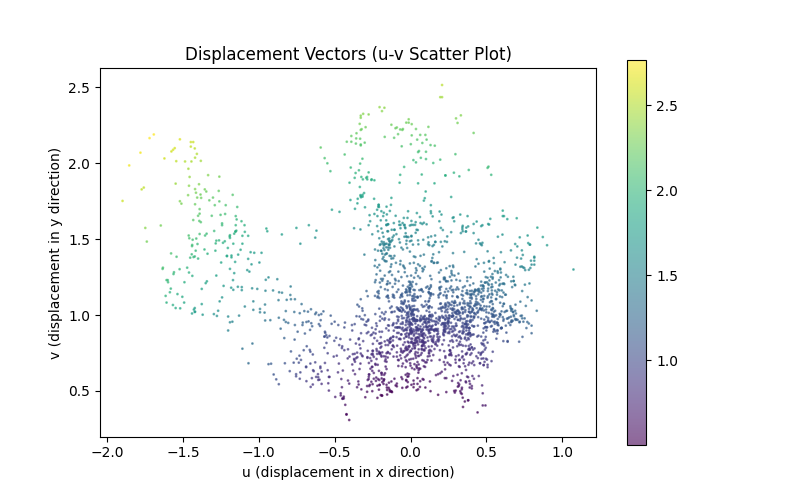

In [12]:
df_features = preproc_features(df)
visualize_uv_plt(df_features)

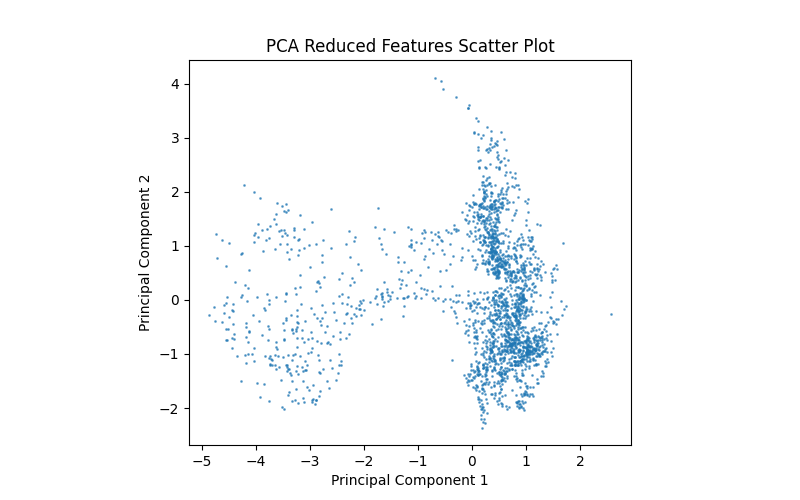

In [13]:
pca_variables = [
    "x",
    "y",
    # "u",
    # "v",
    "V",
    # "angle_deg",
    "u_unit",
    "v_unit",
    # "spatial_index",
    # "log_magnitude",
]
visualize_pca(df_features, columns_to_extract=pca_variables, normalize=True)

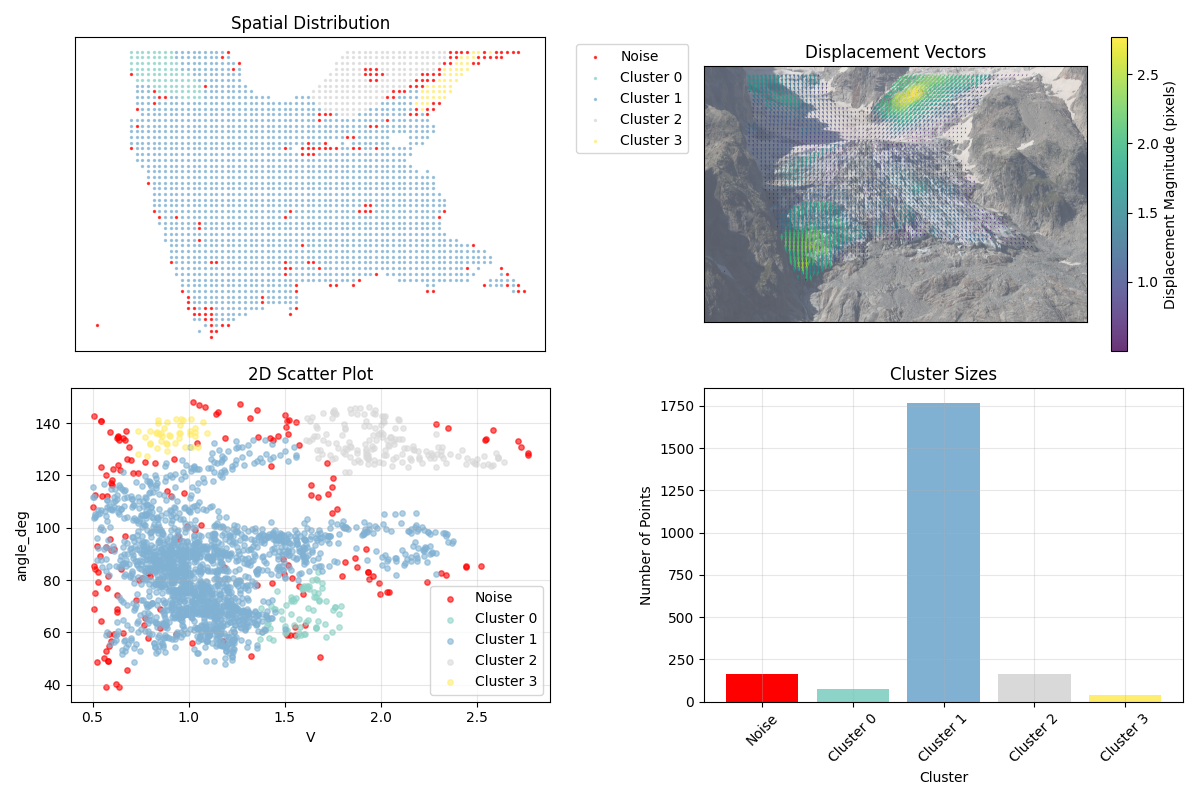

,Cluster,Count,Mean_Magnitude,Mean_Direction,Std_Magnitude
0,Noise,162,1.177476,99.075166,0.628968
1,Cluster 0,76,1.581374,68.134861,0.112997
2,Cluster 1,1766,1.107964,84.685892,0.338999
3,Cluster 2,162,2.023014,132.132794,0.253301
4,Cluster 3,42,0.909644,135.550977,0.093680


In [58]:
# Apply DBSCAN on the spatial weighted features
spatial_weight = 0.2
velocity_weight = 1 - spatial_weight
spatial_features_names = ["x", "y"]
velocity_features_names = ["V", "angle_deg"]

DBSCAN_params = {
    "eps": 0.2,
    "min_samples": 10,
    "metric": "euclidean",
    "algorithm": "auto",
}

df_features = preproc_features(df)
df_features_norm, spatial_scaler, velocity_scaler = normalize_data(
    df_features,
    spatial_weight,
    velocity_weight,
    spatial_features_names,
    velocity_features_names,
)
features = df_features_norm[spatial_features_names + velocity_features_names].values
dbscan = DBSCAN(**DBSCAN_params)
labels = dbscan.fit_predict(features)
df_features["cluster"] = labels

plot_clustering_results(
    df_features,
    labels,
    var_names=velocity_features_names if len(velocity_features_names) == 2 else None,
    img=img,
    figsize=(12, 8),
)